In [1]:
import fileinput
import sys
import os
import argparse
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


def list_file_n_foldes(dir_dist_path):
    """Lista quais sao as pastas e arquivos de um dado caminho"""
    # LISTA TUDO DENTRO DA PASTA
    arquivos = os.listdir(str(dir_dist_path))
    folders = []
    files = []
    for arquivo in arquivos:
        if os.path.isdir(dir_dist_path + r'/' + arquivo):
            folders.append(dir_dist_path + r'/' + arquivo)
        else:
            files.append(dir_dist_path + r'/' + arquivo)
    return files, folders

# WINDOWS
# folder_path = r'\\wsl.localhost\Ubuntu-20.04\home\william\ns-3\ns-allinone-3.40\ns-3.40\resultados_william'

# UBUNTU
# folder_path = r'/home/william/ns-3/ns-allinone-3.40/ns-3.40/resultados_william/2_link_distance_6_24hz'
folder_path = r'/home/william/ns-3/ns-allinone-3.40/ns-3.40/resultados_william'

banda_filter = 40
gi_filter = 800

files, folders = list_file_n_foldes(folder_path)

columns = ['MCS', 'Channel_width', 'GI', 'Throughput', 'Frequency', 'Frequency2', 'Distance']
all_data = pd.DataFrame(columns=columns)
print(all_data)

for folder in folders:
    folder_name = folder.split('/')[-1]
    print(folder_name)

    n_links = int(folder_name.split('_')[0])
    type_sim = folder_name.split('_')[2]
    freq1 = folder_name.split('_')[3].split('hz')[0]
    if n_links > 1:
        freq2 = folder_name.split('_')[4].split('hz')[0]
    else:
        freq2 = None
    print(f"n_links: {n_links}, type_sim: {type_sim}, freq1: {freq1}, freq2: {freq2}")

    if n_links == 1 or n_links == 2:
        sim_files, sub_folders = list_file_n_foldes(folder)
        print(f"sim_files: {sim_files}")
        for i, file_t in enumerate(sim_files):

            # PEGA DADOS DO TITULO DO ARQUIVO
            path_names = file_t.split('/')
            file_name = path_names[-1]
            simulation_title_parts = file_name.split('_')

            frequency = float(simulation_title_parts[0])
            if n_links == 2:
                frequency2 = float(simulation_title_parts[1])
                dist = int(simulation_title_parts[3].replace('m', ''))
            elif n_links == 1:
                frequency2 = float(0)
                dist = int(simulation_title_parts[2].replace('m', ''))

            file_path = file_t
            print(f"file_path: {file_path}")

            # Ler o arquivo de texto
            with open(file_path, 'r', encoding='utf-8') as file:
                lines = file.readlines()

            print(f"lines: {len(lines)}")

            # VERIFICA SE A SAIDA DA SIMULACAO ESTA MINIMAMENTE COERENTE, SE N PULA PRA O PROXIMO
            if frequency == 2.4 and len(lines) < 6:
                # print(file)
                # print('QUEBRADO!!!')
                continue
            elif frequency != 2.4 and len(lines) < 13:
                # print(file)
                # print('QUEBRADO!!!')
                continue

            # Processar as linhas para extrair as informações
            data = []
            for line in lines[1:]:  # Pular o cabeçalho

                if 'Command' in line:
                    continue

                # print(line)
                # RETIRA AS UNIDADES DOS DADOS
                line = line.replace('Mbit/s', '')
                line = line.replace('MHz', '')
                line = line.replace('ns', '')
                # print(line)

                # Dividir a linha por tabulações ou múltiplos espaços
                parts = line.split()
                # print('parts:', parts)

                # # Adicionar os dados à lista
                mcs_value = int(parts[0])
                channel_width = int(parts[1])
                gi = int(parts[2])
                throughput = float(parts[3])

                # ADICIONA OS DADOS
                data.append([mcs_value, channel_width, gi, throughput, frequency, frequency2, dist])

            # Criar um DataFrame a partir dos dados
            columns = ['MCS', 'Channel_width', 'GI', 'Throughput', 'Frequency', 'Frequency2', 'Distance']
            df = pd.DataFrame(data, columns=columns)

            # print(df)
            all_data = pd.concat([all_data, df], ignore_index=True)

            # FILTRO
            subset_complex = df[((df['Channel_width'] == banda_filter) & (df['GI'] == gi_filter))]

            # TODO > DESCOBRIR COMO PEGA 1 VALOR ESPECIFICO DO DATA FRAME
            # TODO > POR ENQUANTO TO PASSANDO O MAIOR VALOR DO DF
            tput = subset_complex['Throughput']

            # linha_data = {'Distance': dist, 'Throughput': tput.max()}

print("all_data")
print(all_data)


Empty DataFrame
Columns: [MCS, Channel_width, GI, Throughput, Frequency, Frequency2, Distance]
Index: []
1_link_distance_5hz
n_links: 1, type_sim: distance, freq1: 5, freq2: None
sim_files: ['/home/william/ns-3/ns-allinone-3.40/ns-3.40/resultados_william/1_link_distance_5hz/5_dist_5m_1717594409224.txt', '/home/william/ns-3/ns-allinone-3.40/ns-3.40/resultados_william/1_link_distance_5hz/5_dist_3m_1717594349197.txt', '/home/william/ns-3/ns-allinone-3.40/ns-3.40/resultados_william/1_link_distance_5hz/5_dist_8m_1717594447589.txt', '/home/william/ns-3/ns-allinone-3.40/ns-3.40/resultados_william/1_link_distance_5hz/5_dist_7m_1717594437910.txt', '/home/william/ns-3/ns-allinone-3.40/ns-3.40/resultados_william/1_link_distance_5hz/5_dist_9m_1717594455865.txt', '/home/william/ns-3/ns-allinone-3.40/ns-3.40/resultados_william/1_link_distance_5hz/5_dist_2m_1717594275796.txt', '/home/william/ns-3/ns-allinone-3.40/ns-3.40/resultados_william/1_link_distance_5hz/5_dist_6m_1717594426021.txt', '/home/will

Channel_width
20     174
40     172
80      87
160     87
Name: count, dtype: int64


<Axes: >

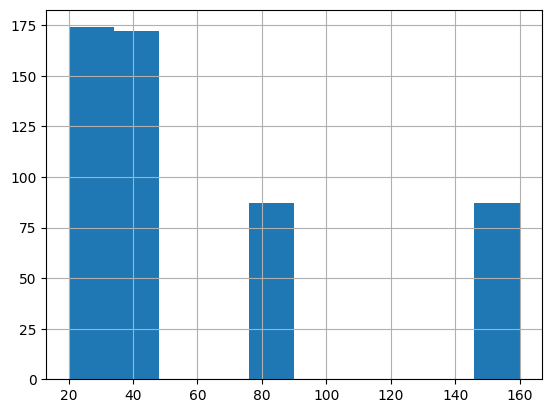

In [2]:
# PEGA SO UMA COLUNA
coluna_cw = all_data['Channel_width']
# CONTA QUANTAS LINHAS (REPETICOES) TEM PARA CADA VALOR DESSA COLUNA
print(coluna_cw.value_counts())
coluna_cw.hist()

In [3]:
all_data

,MCS,Channel_width,GI,Throughput,Frequency,Frequency2,Distance
0,12,20,3200,90.2272,5.0,0.0,5
1,12,20,1600,91.6608,5.0,0.0,5
2,12,20,800,103.3540,5.0,0.0,5
3,12,40,3200,167.0820,5.0,0.0,5
4,12,40,1600,174.6980,5.0,0.0,5
...,...,...,...,...,...,...,...
515,12,80,1600,512.4220,6.0,5.0,1
516,12,80,800,552.4060,6.0,5.0,1
517,12,160,3200,707.7950,6.0,5.0,1
518,12,160,1600,714.9630,6.0,5.0,1


In [4]:
# Suponha que temos um DataFrame chamado 'df'
# df_filtered = all_data[(all_data['Frequency'] == 5) & (all_data['Frequency2'] == 6)]
df_filtered = all_data[(all_data['Frequency'] == 5) & (all_data['Frequency2'] == 0)]
pd.options.mode.copy_on_write = True

df_filtered

,MCS,Channel_width,GI,Throughput,Frequency,Frequency2,Distance
0,12,20,3200,90.2272,5.0,0.0,5
1,12,20,1600,91.6608,5.0,0.0,5
2,12,20,800,103.3540,5.0,0.0,5
3,12,40,3200,167.0820,5.0,0.0,5
4,12,40,1600,174.6980,5.0,0.0,5
...,...,...,...,...,...,...,...
91,12,80,1600,306.7230,5.0,0.0,4
92,12,80,800,335.1040,5.0,0.0,4
93,12,160,3200,0.0000,5.0,0.0,4
94,12,160,1600,0.0000,5.0,0.0,4


In [5]:

df_filtered["CW_GI"] = df_filtered["Channel_width"].astype(str) +"_"+  df_filtered["GI"].astype(str)
df_filtered["F1_F2"] = df_filtered["Frequency"].astype(str) +"_"+  df_filtered["Frequency2"].astype(str)

df_selected = df_filtered[['F1_F2', 'CW_GI', 'Distance', 'Throughput']] 
# df_selected.plot()

df_selected

,F1_F2,CW_GI,Distance,Throughput
0,5.0_0.0,20_3200,5,90.2272
1,5.0_0.0,20_1600,5,91.6608
2,5.0_0.0,20_800,5,103.3540
3,5.0_0.0,40_3200,5,167.0820
4,5.0_0.0,40_1600,5,174.6980
...,...,...,...,...
91,5.0_0.0,80_1600,4,306.7230
92,5.0_0.0,80_800,4,335.1040
93,5.0_0.0,160_3200,4,0.0000
94,5.0_0.0,160_1600,4,0.0000


<Axes: xlabel='Distance'>

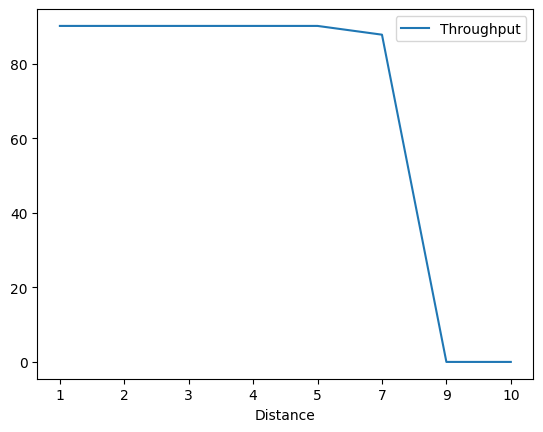

In [6]:
filtrado = df_selected.filter(items=['Distance','Throughput'])\
    .where(df_selected.CW_GI == '20_3200')\
    .dropna(how='any')\
    .sort_values(by='Distance')

filtrado = filtrado.dropna(how='any')
# filtrado.plot()

filtrado.plot(x="Distance", y="Throughput")

160_1600
160_3200
160_800
20_1600
20_3200
20_800
40_1600
40_3200
40_800
80_1600
80_3200
80_800


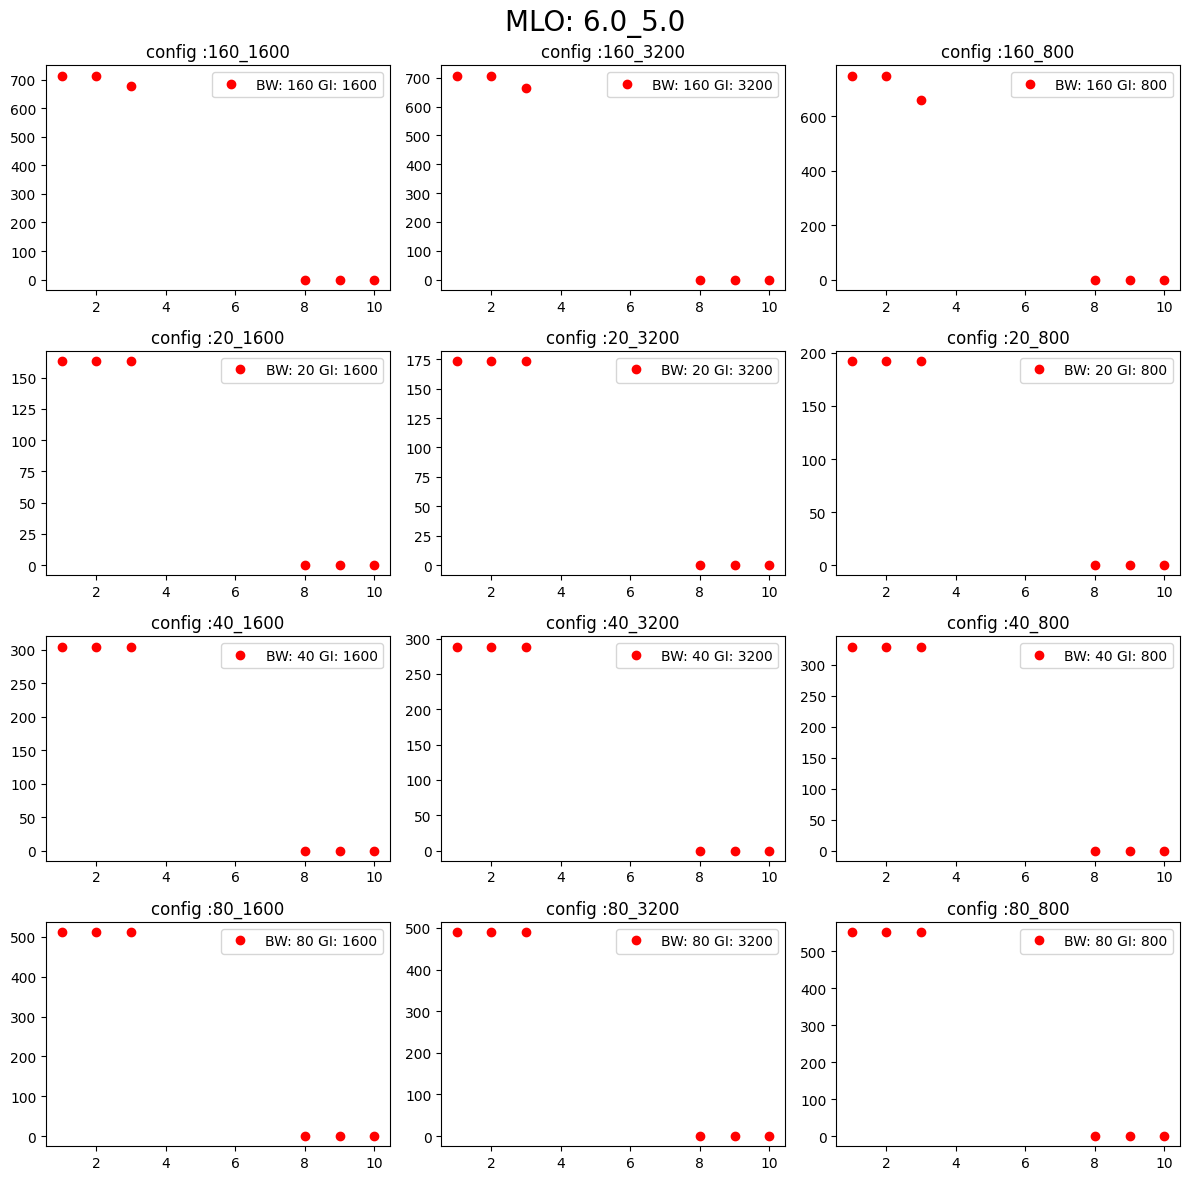

160_1600
160_3200
160_800
20_1600
20_3200
20_800
40_1600
40_3200
40_800
80_1600
80_3200
80_800


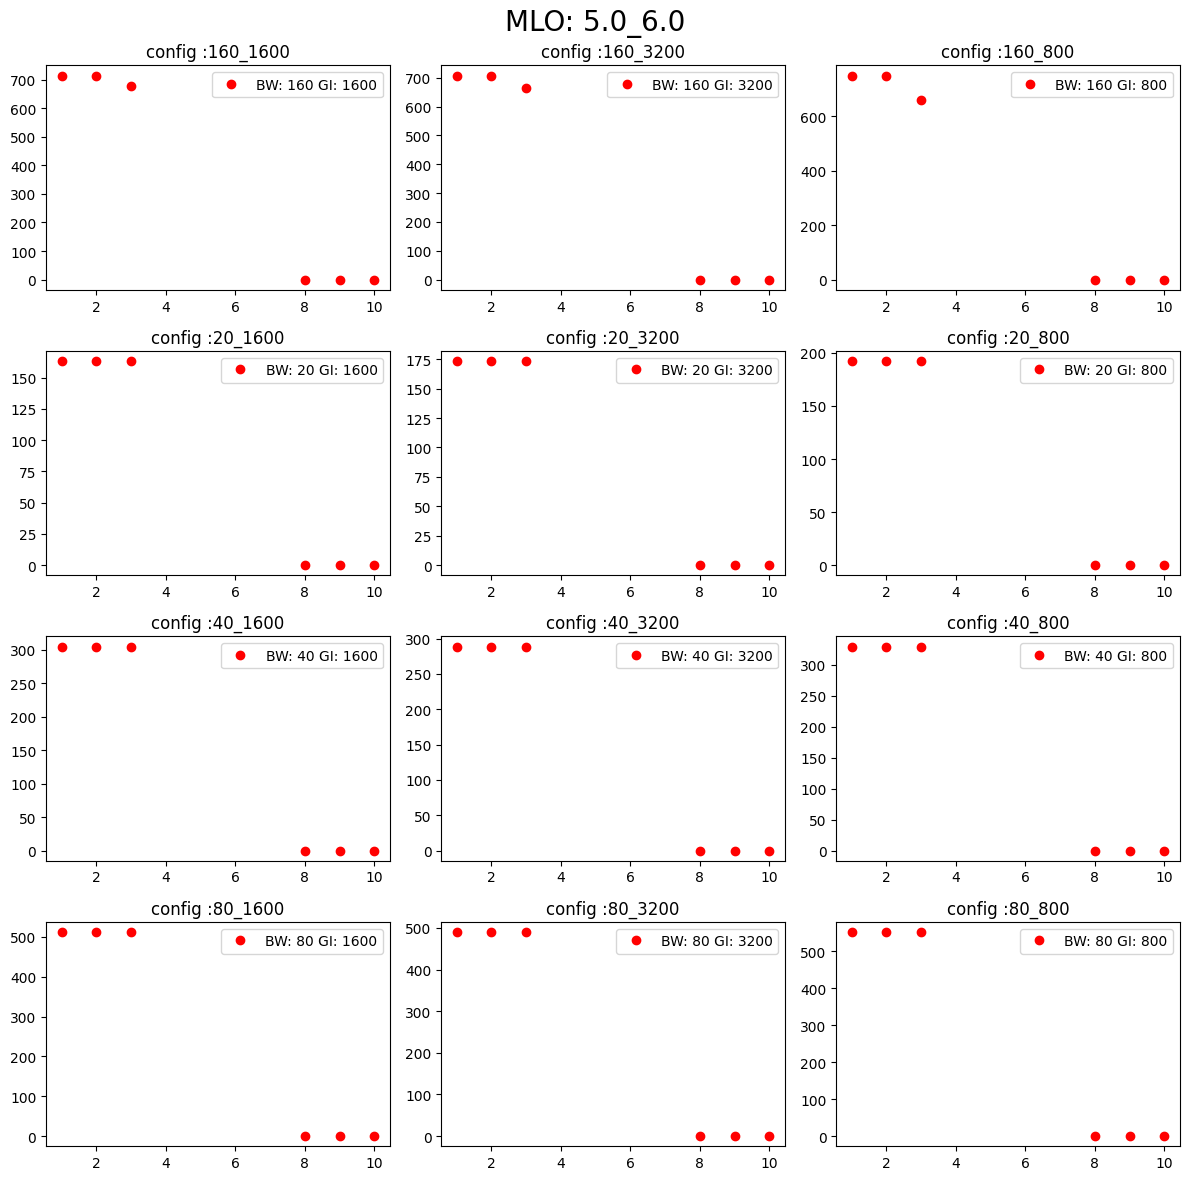

160_1600
160_3200
160_800
20_1600
20_3200
20_800
40_1600
40_3200
40_800
80_1600
80_3200
80_800


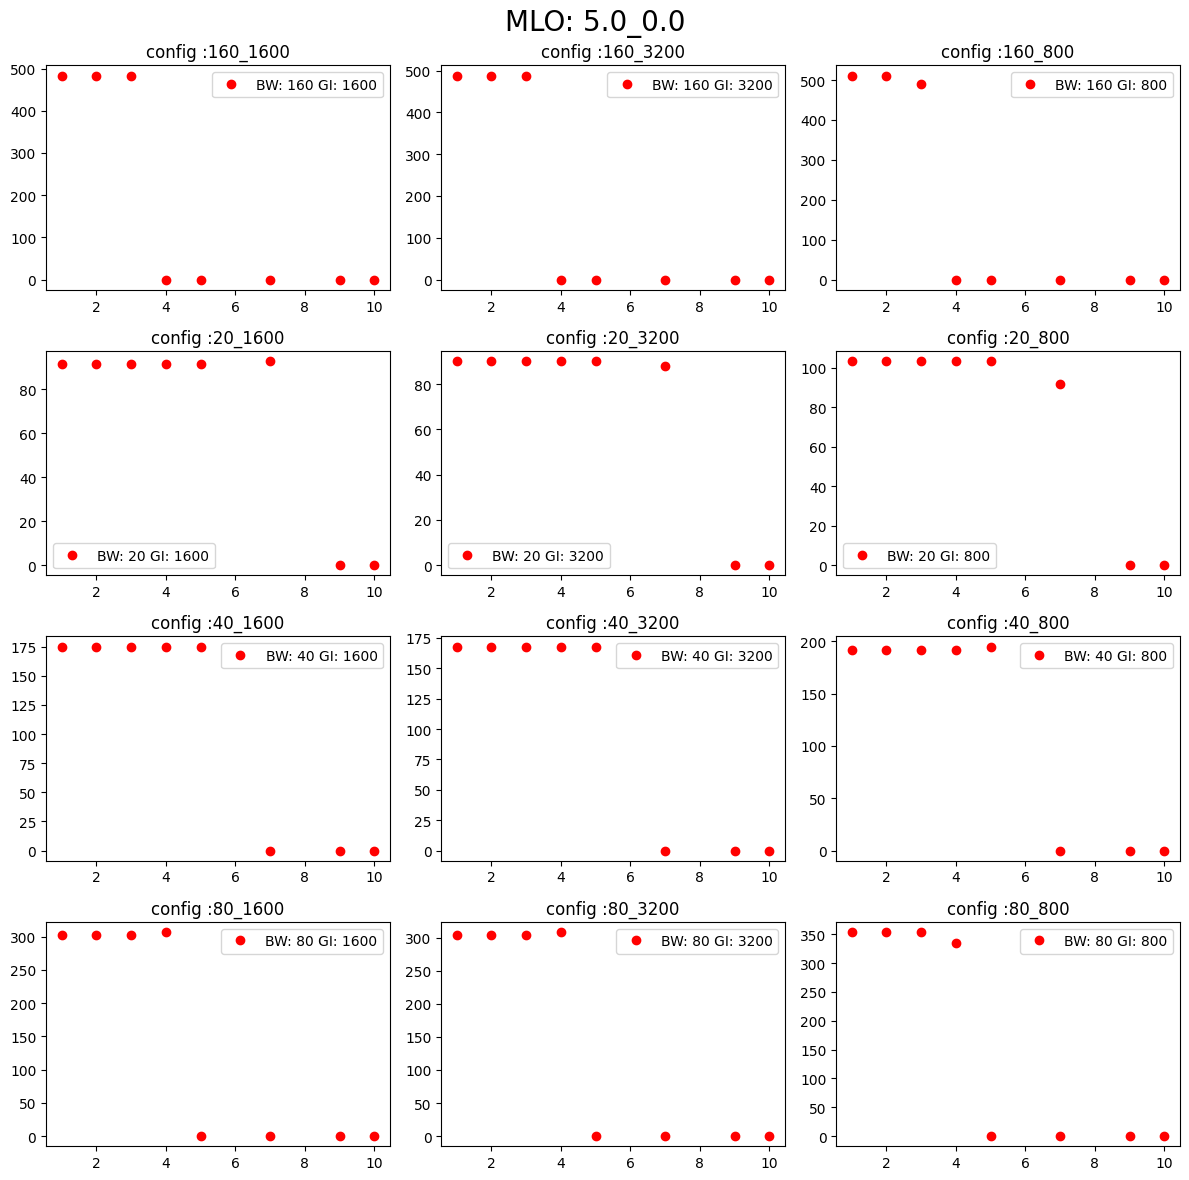

160_1600
160_3200
160_800
20_1600
20_3200
20_800
40_1600
40_3200
40_800
80_1600
80_3200
80_800


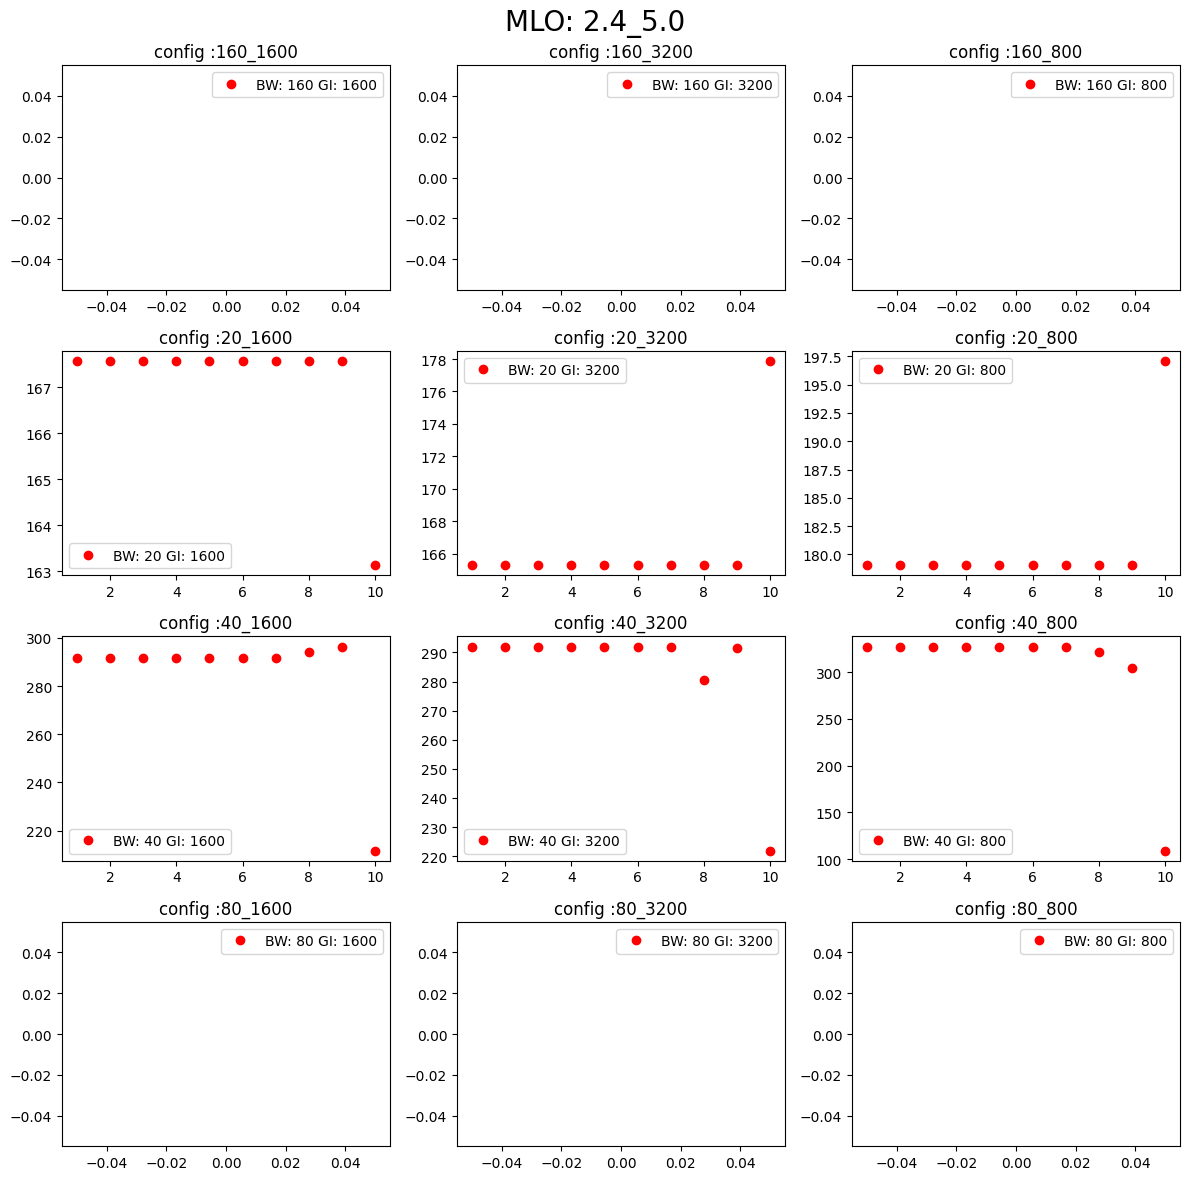

160_1600
160_3200
160_800
20_1600
20_3200
20_800
40_1600
40_3200
40_800
80_1600
80_3200
80_800


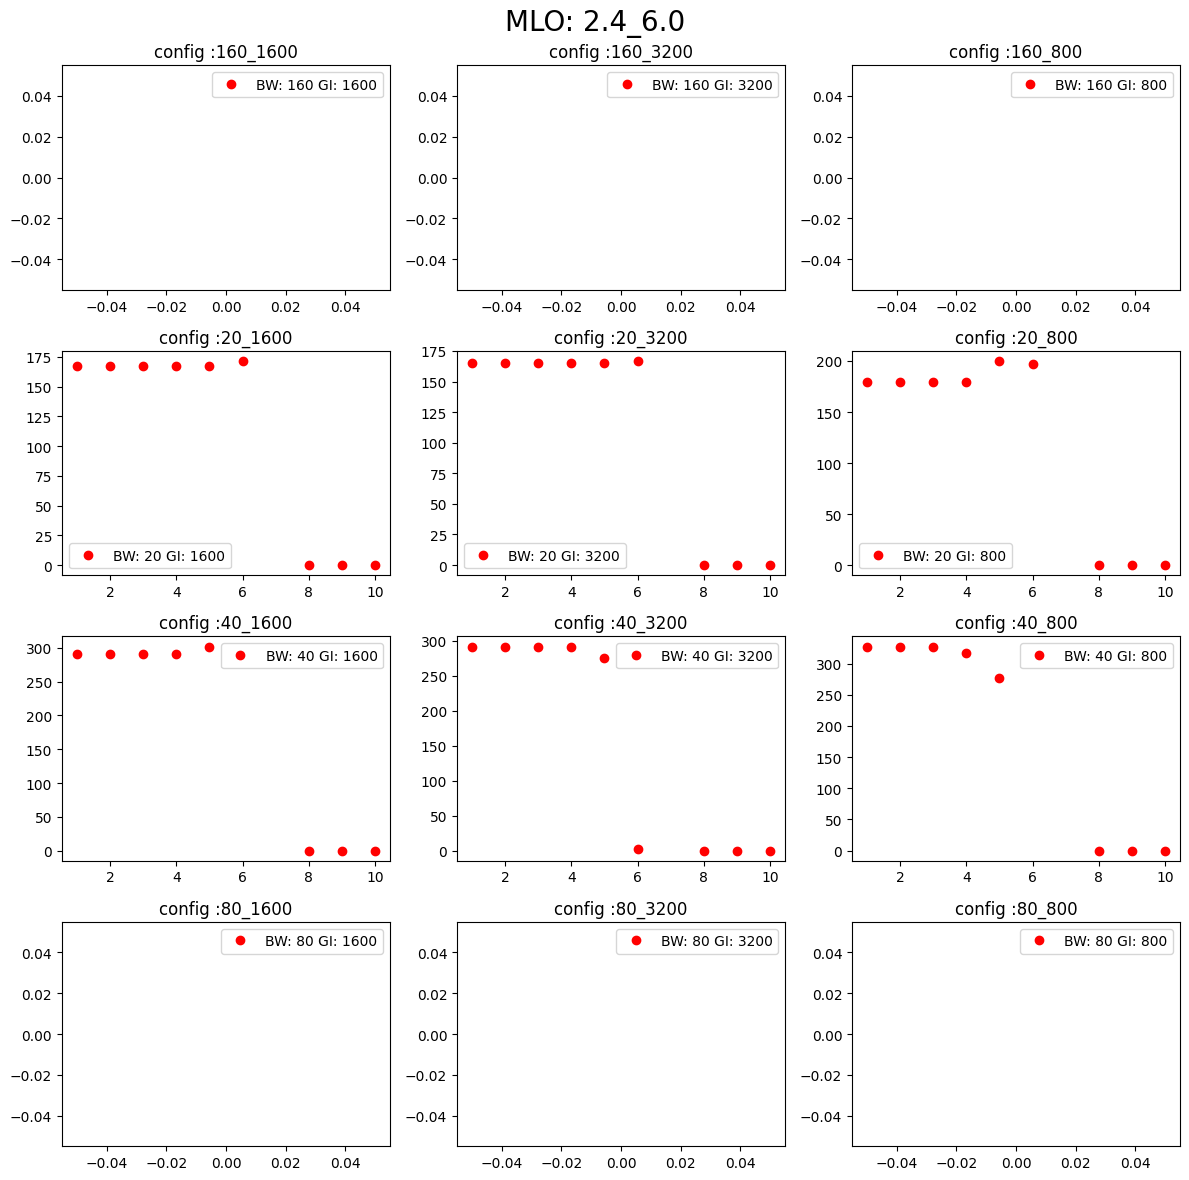

160_1600
160_3200
160_800
20_1600
20_3200
20_800
40_1600
40_3200
40_800
80_1600
80_3200
80_800


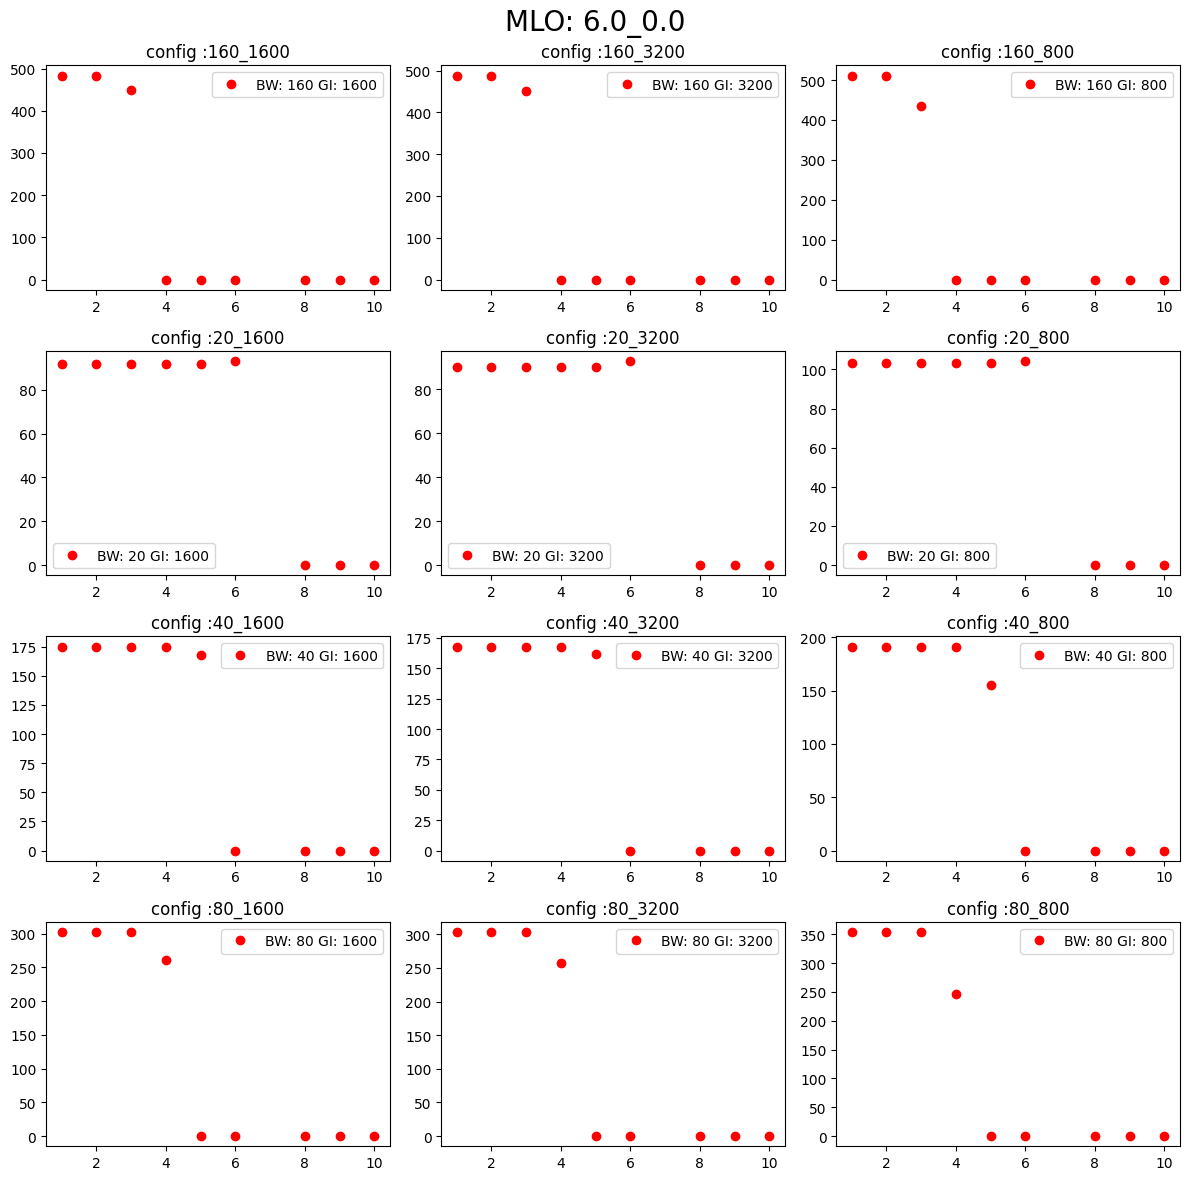

160_1600
160_3200
160_800
20_1600
20_3200
20_800
40_1600
40_3200
40_800
80_1600
80_3200
80_800


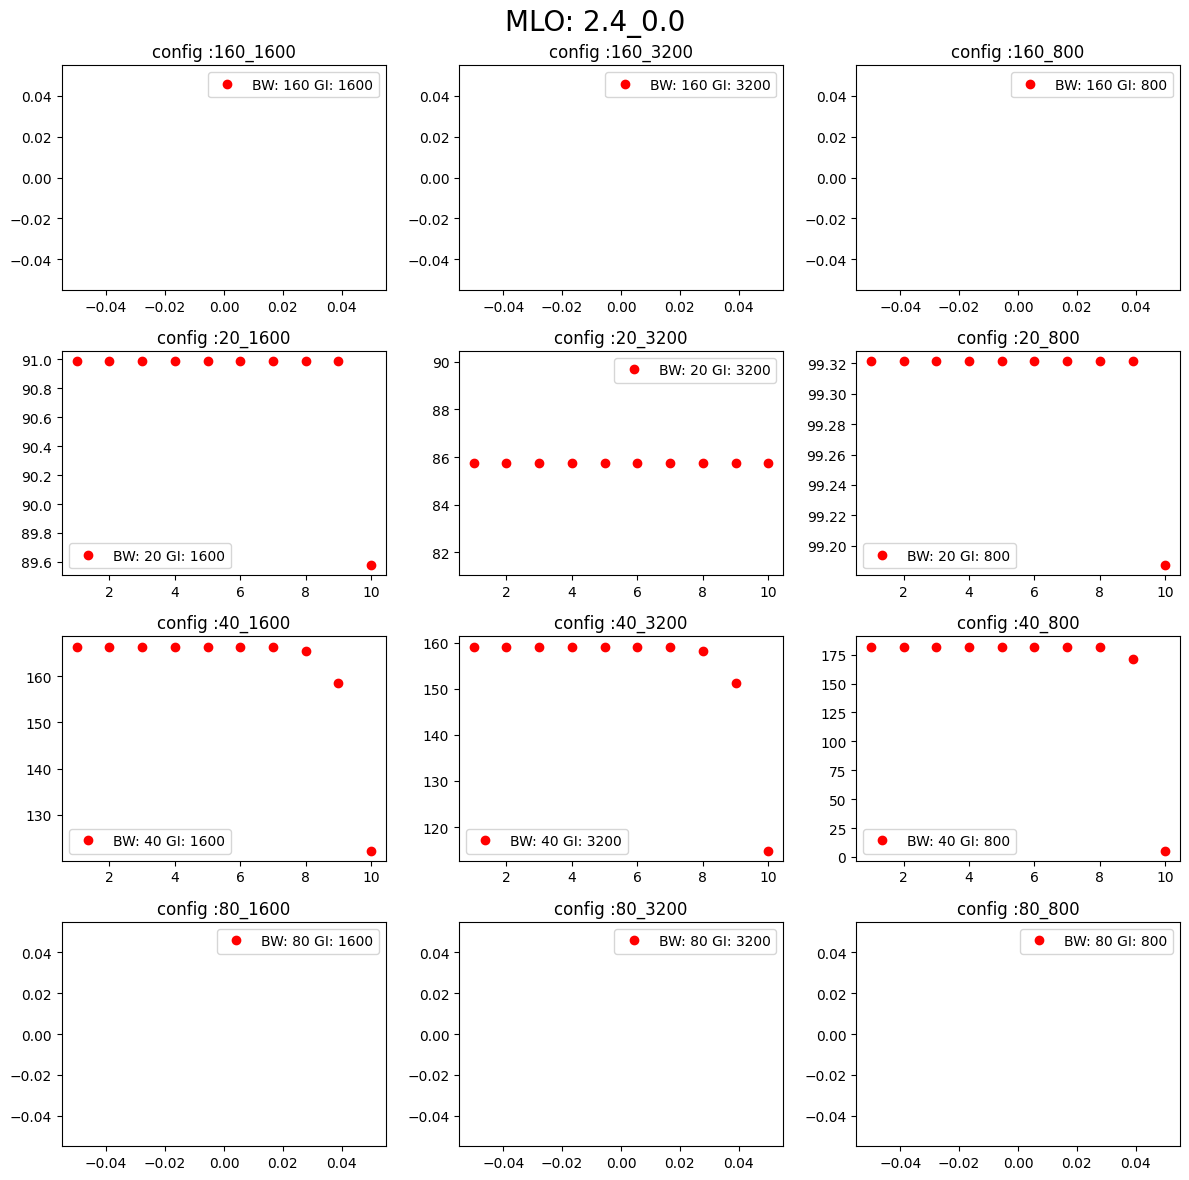

In [7]:
all_data["CW_GI"] = all_data["Channel_width"].astype(str) +"_"+  all_data["GI"].astype(str)
all_data["F1_F2"] = all_data["Frequency"].astype(str) +"_"+  all_data["Frequency2"].astype(str)

all_data = all_data.sort_values(by='Distance')


mlos = all_data['F1_F2'].unique()
for mlo in mlos:
    filtered_by_mlo = all_data.filter(items=['F1_F2', 'CW_GI', 'Distance', 'Throughput'])\
            .where(all_data.F1_F2 == mlo)\
            .dropna(how='any')\
            .sort_values(by='Distance')


    nw_configs = all_data.sort_values(by='CW_GI')
    nw_configs = nw_configs['CW_GI'].unique()
    
    
    # Criando a figura e os subplots
    fig, axs = plt.subplots(4, 3, figsize=(12, 12))
    fig.suptitle(F"MLO: {mlo}",size=20)
    
    for i, nconfig in enumerate(nw_configs):
        print(nconfig)
    
        filtrado = filtered_by_mlo.filter(items=['Distance','Throughput'])\
            .where(filtered_by_mlo.CW_GI == nconfig)\
            .dropna(how='any')\
            .sort_values(by='Distance')
    
        filtrado = filtrado.dropna(how='any')
    
        x = filtrado['Distance']
        y = filtrado['Throughput']
        
        ax = axs.flat[i]
        # ax.plot(x, y, 'ro' , label=f'Subplot {nconfig}', )
        rede = nconfig.split('_')
        ax.plot(x, y, 'ro' , label=f'BW: {rede[0]} GI: {rede[1]}', )
        ax.set_title(f'config :{nconfig}')
        ax.legend()
    
        
        # filtrado.plot(x="Distance", y="Throughput")
    
    # Ajustando o layout
    plt.tight_layout()
    
    # Mostrando o gráfico
    plt.show()


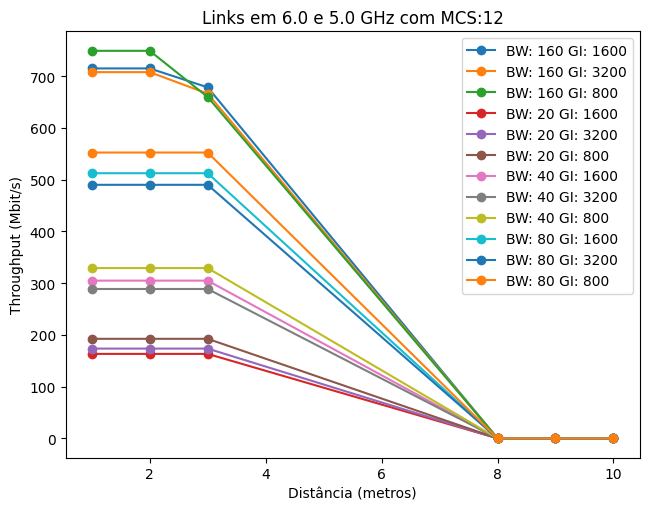

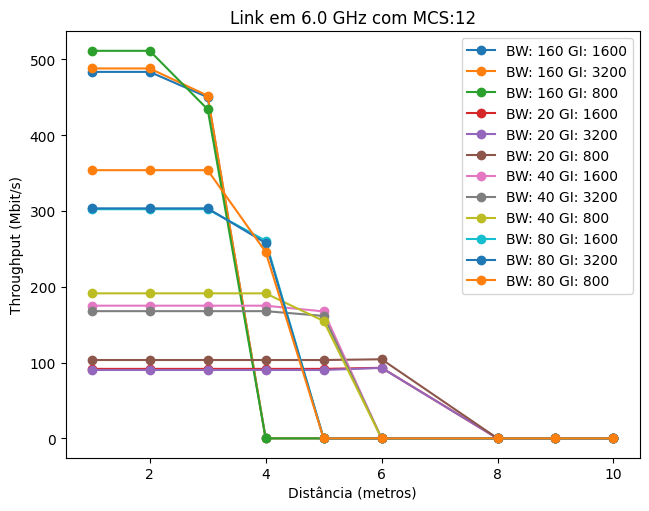

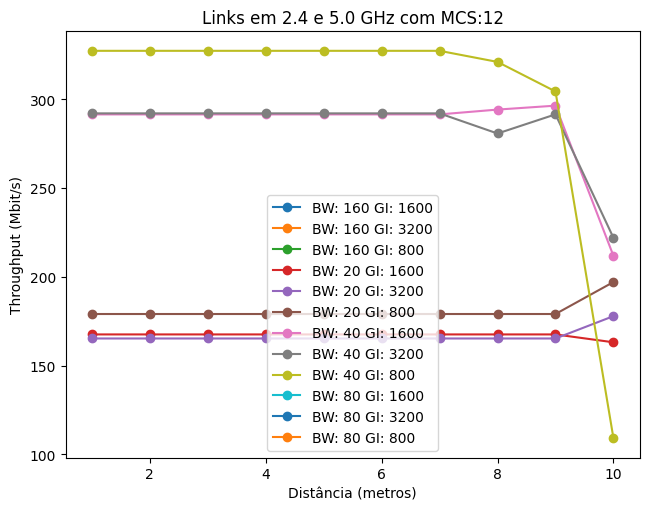

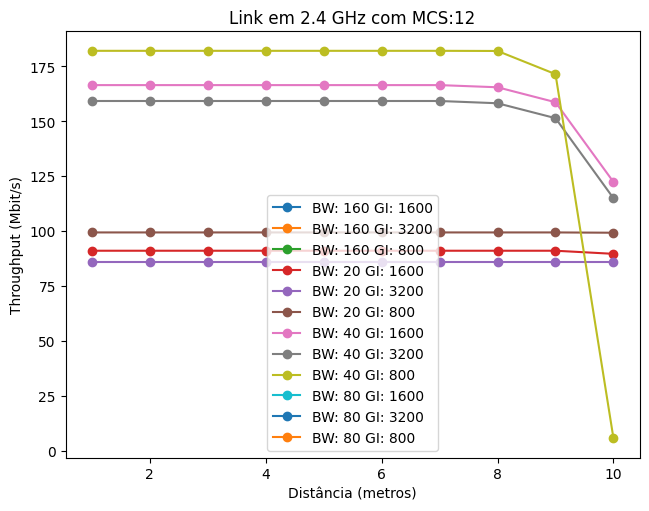

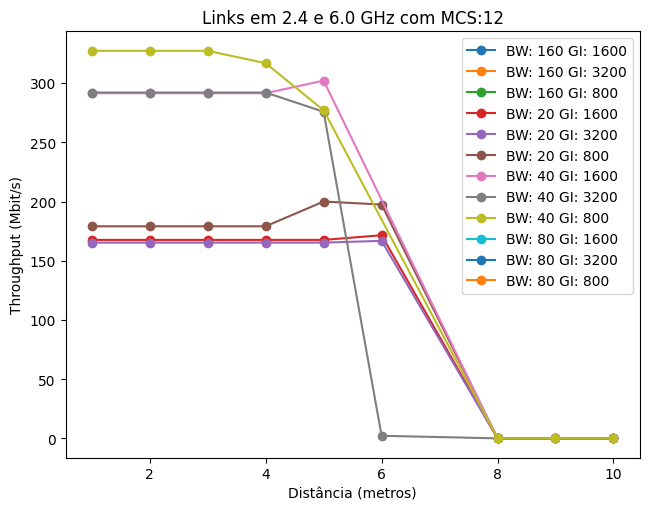

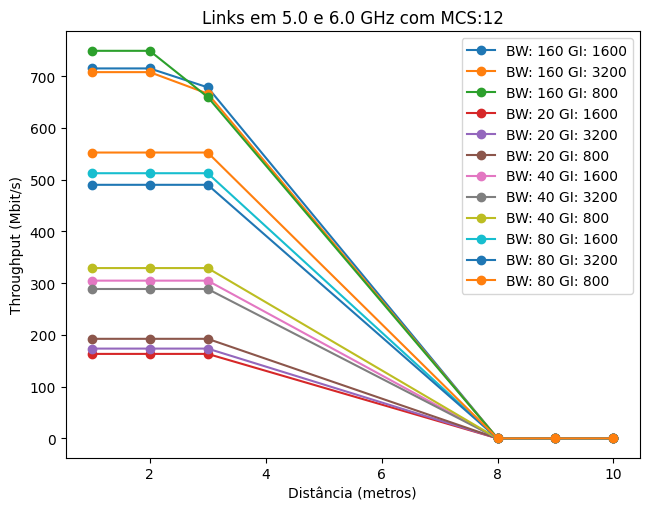

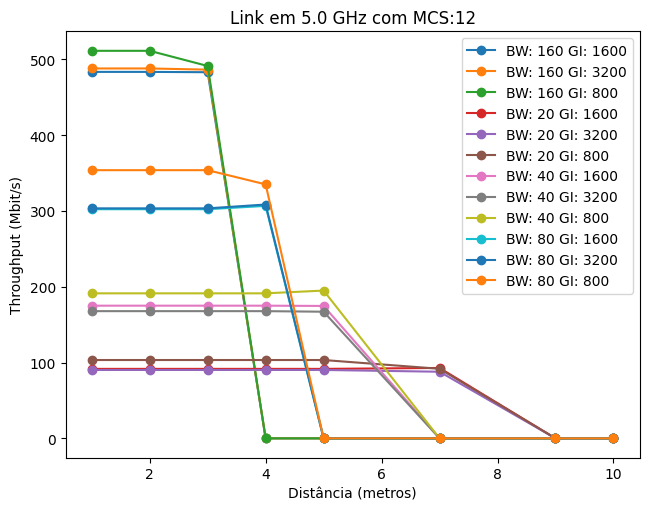

In [8]:
all_data["CW_GI"] = all_data["Channel_width"].astype(str) +"_"+  all_data["GI"].astype(str)
all_data["F1_F2"] = all_data["Frequency"].astype(str) +"_"+  all_data["Frequency2"].astype(str)

all_data = all_data.sort_values(by='Distance')


mlos = all_data['F1_F2'].unique()
for mlo in mlos:
    filtered_by_mlo = all_data.filter(items=['F1_F2', 'CW_GI', 'Distance', 'Throughput'])\
            .where(all_data.F1_F2 == mlo)\
            .dropna(how='any')\
            .sort_values(by='Distance')


    nw_configs = all_data.sort_values(by='CW_GI')
    nw_configs = nw_configs['CW_GI'].unique()
    
    
    # Criando a figura e os subplots
    fig = plt.plot(figsize=(12, 8))
    
    for i, nconfig in enumerate(nw_configs):
        # print(nconfig)
    
        filtrado = filtered_by_mlo.filter(items=['Distance','Throughput'])\
            .where(filtered_by_mlo.CW_GI == nconfig)\
            .dropna(how='any')\
            .sort_values(by='Distance')
    
        filtrado = filtrado.dropna(how='any')
    
        x = filtrado['Distance']
        y = filtrado['Throughput']
        
        # ax = axs.flat[i]
        # ax.plot(x, y, 'ro' , label=f'Subplot {nconfig}', )
        rede = nconfig.split('_')
        plt.plot(x, y, '-o', label=f'BW: {rede[0]} GI: {rede[1]}', )
        # plt.set_title(f'config :{nconfig}')
        plt.legend()
    
        
        # filtrado.plot(x="Distance", y="Throughput")
    
    # Ajustando o layout
    plt.tight_layout()
    l1, l2 = mlo.split('_')
    if l2 == '0.0':
        titulo = f'Link em {l1} GHz'
    else:
        titulo = f'Links em {l1} e {l2} GHz'
    
    plt.title(f"{titulo} com MCS:12")
    plt.xlabel('Distância (metros)')
    plt.ylabel('Throughput (Mbit/s)')
    # Mostrando o gráfico
    plt.show()


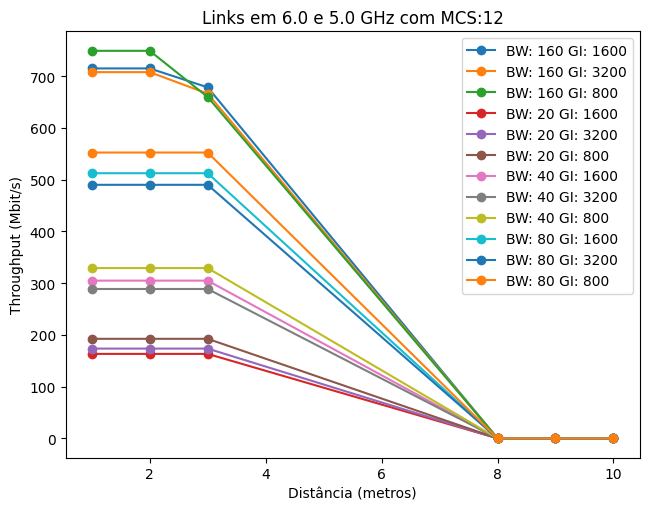

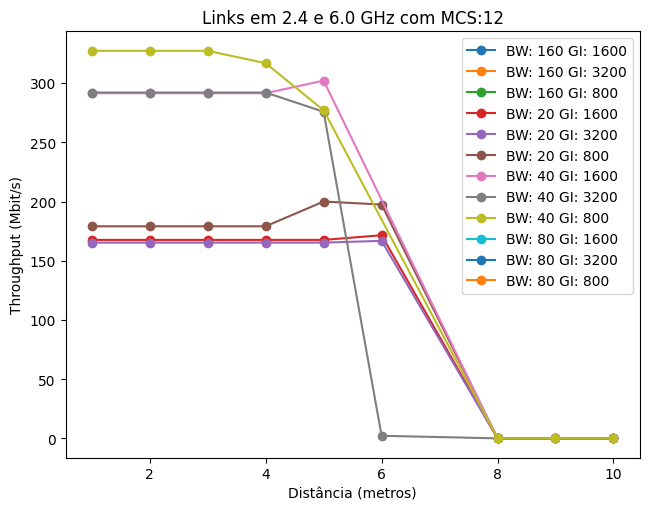

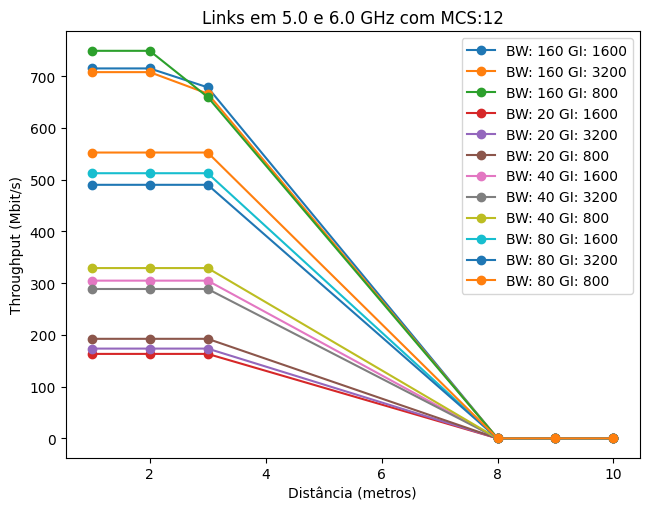

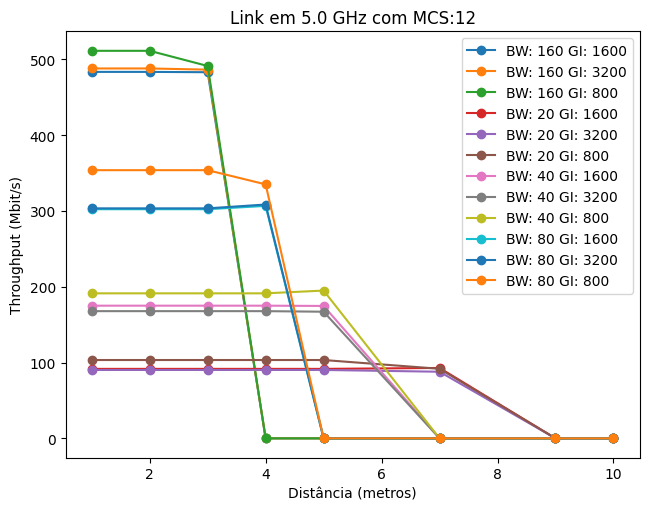

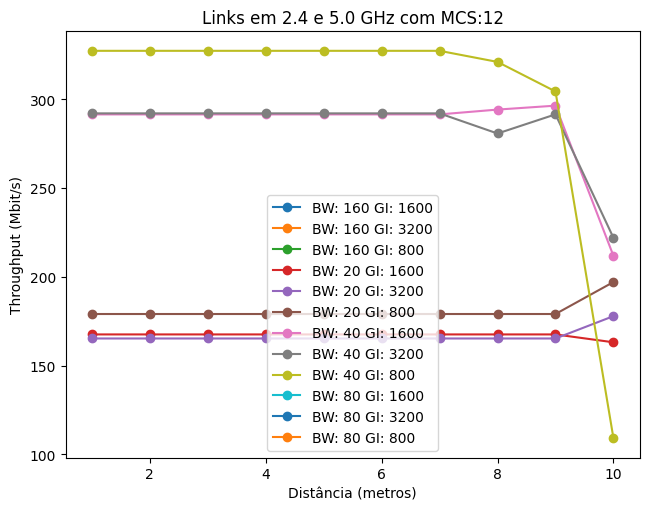

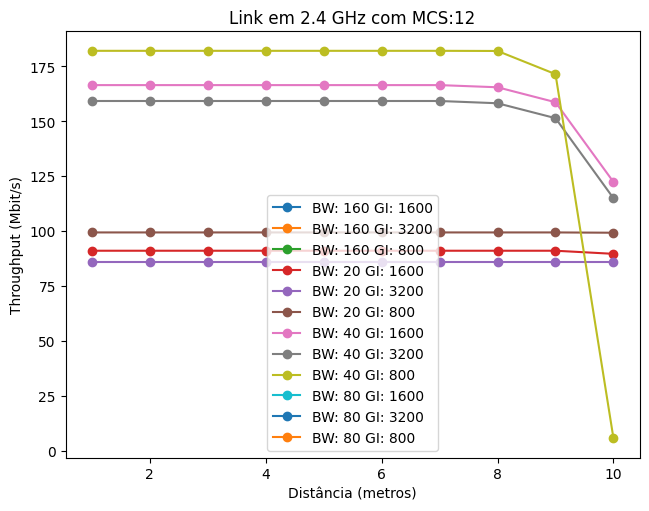

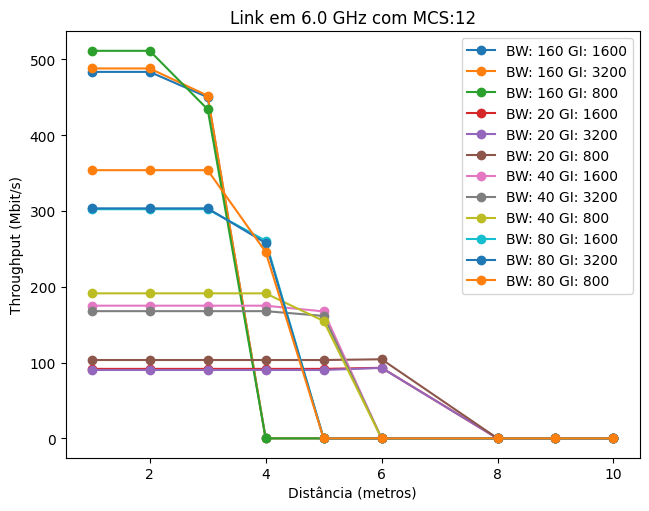

In [9]:
all_data["CW_GI"] = all_data["Channel_width"].astype(str) +"_"+  all_data["GI"].astype(str)
all_data["F1_F2"] = all_data["Frequency"].astype(str) +"_"+  all_data["Frequency2"].astype(str)

all_data = all_data.sort_values(by='Distance')


mlos = all_data['F1_F2'].unique()
for mlo in mlos:
    filtered_by_mlo = all_data.filter(items=['F1_F2', 'CW_GI', 'Distance', 'Throughput'])\
            .where(all_data.F1_F2 == mlo)\
            .dropna(how='any')\
            .sort_values(by='Distance')


    nw_configs = all_data.sort_values(by='CW_GI')
    nw_configs = nw_configs['CW_GI'].unique()
    
    
    # Criando a figura e os subplots
    fig = plt.plot(figsize=(12, 8))
    
    for i, nconfig in enumerate(nw_configs):
        # print(nconfig)
    
        filtrado = filtered_by_mlo.filter(items=['Distance','Throughput'])\
            .where(filtered_by_mlo.CW_GI == nconfig)\
            .dropna(how='any')\
            .sort_values(by='Distance')
    
        filtrado = filtrado.dropna(how='any')
    
        x = filtrado['Distance']
        y = filtrado['Throughput']
        
        # ax = axs.flat[i]
        # ax.plot(x, y, 'ro' , label=f'Subplot {nconfig}', )
        rede = nconfig.split('_')
        plt.plot(x, y, '-o', label=f'BW: {rede[0]} GI: {rede[1]}', )
        # plt.set_title(f'config :{nconfig}')
        plt.legend()
    
        
        # filtrado.plot(x="Distance", y="Throughput")
    
    # Ajustando o layout
    plt.tight_layout()
    l1, l2 = mlo.split('_')
    if l2 == '0.0':
        titulo = f'Link em {l1} GHz'
    else:
        titulo = f'Links em {l1} e {l2} GHz'
    
    plt.title(f"{titulo} com MCS:12")
    plt.xlabel('Distância (metros)')
    plt.ylabel('Throughput (Mbit/s)')
    # Mostrando o gráfico
    plt.show()


40_800
20_3200
40_800
20_3200


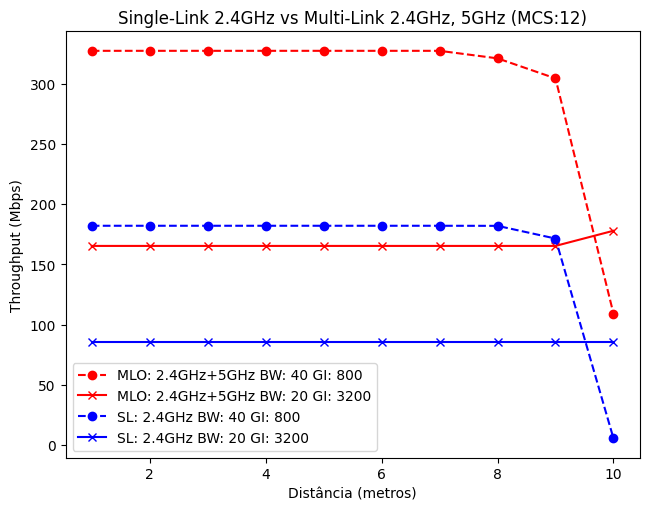

In [32]:
all_data["CW_GI"] = all_data["Channel_width"].astype(str) +"_"+  all_data["GI"].astype(str)
all_data["F1_F2"] = all_data["Frequency"].astype(str) +"_"+  all_data["Frequency2"].astype(str)

all_data = all_data.sort_values(by='Distance')


mlos = all_data['F1_F2'].unique()


mlo = '2.4_5.0'
filtered_by_mlo = all_data.filter(items=['F1_F2', 'CW_GI', 'Distance', 'Throughput'])\
        .where(all_data.F1_F2 == mlo)\
        .dropna(how='any')\
        .sort_values(by='Distance')

# Criando a figura e os subplots
fig = plt.plot(figsize=(8, 6))

nw_configs = ['40_800', '20_3200']

for i, nconfig in enumerate(nw_configs):
    print(nconfig)
    l1, l2 = mlo.split('_')
    filtrado = filtered_by_mlo.filter(items=['Distance','Throughput'])\
        .where(filtered_by_mlo.CW_GI == nconfig)\
        .dropna(how='any')\
        .sort_values(by='Distance')

    filtrado = filtrado.dropna(how='any')

    x = filtrado['Distance']
    y = filtrado['Throughput']
    
    # ax = axs.flat[i]
    # ax.plot(x, y, 'ro' , label=f'Subplot {nconfig}', )
    rede = nconfig.split('_')
    if i==0:
        plt.plot(x, y, '--o', color='red', label=f'MLO: {l1}GHz+{int(float(l2))}GHz BW: {rede[0]} GI: {rede[1]}', )
    else:
        plt.plot(x, y, '-x', color='red', label=f'MLO: {l1}GHz+{int(float(l2))}GHz BW: {rede[0]} GI: {rede[1]}', )
    # plt.set_title(f'config :{nconfig}')
    plt.legend()


mlo = '2.4_0.0'
filtered_by_mlo = all_data.filter(items=['F1_F2', 'CW_GI', 'Distance', 'Throughput'])\
        .where(all_data.F1_F2 == mlo)\
        .dropna(how='any')\
        .sort_values(by='Distance')

# Criando a figura e os subplots
fig = plt.plot(figsize=(8, 4))

nw_configs = ['40_800', '20_3200']

for i, nconfig in enumerate(nw_configs):
    print(nconfig)
    l1, l2 = mlo.split('_')
    filtrado = filtered_by_mlo.filter(items=['Distance','Throughput'])\
        .where(filtered_by_mlo.CW_GI == nconfig)\
        .dropna(how='any')\
        .sort_values(by='Distance')

    filtrado = filtrado.dropna(how='any')

    x = filtrado['Distance']
    y = filtrado['Throughput']
    
    # ax = axs.flat[i]
    # ax.plot(x, y, 'ro' , label=f'Subplot {nconfig}', )
    rede = nconfig.split('_')
    if i==0:
        plt.plot(x, y, '--o', color='blue', label=f'SL: {l1}GHz BW: {rede[0]} GI: {rede[1]}', )
    else:
        plt.plot(x, y, '-x', color='blue', label=f'SL: {l1}GHz BW: {rede[0]} GI: {rede[1]}', )
    # plt.set_title(f'config :{nconfig}')
    plt.legend()

    
    # filtrado.plot(x="Distance", y="Throughput")


# Ajustando o layout
plt.tight_layout()
l1, l2 = mlo.split('_')
if l2 == '0.0':
    titulo = f'Link em {l1} GHz'
else:
    titulo = f'Links em {l1} e {l2} GHz'

plt.title(f"Single-Link 2.4GHz vs Multi-Link 2.4GHz, 5GHz (MCS:12)")
plt.xlabel('Distância (metros)')
plt.ylabel('Throughput (Mbps)')
# Mostrando o gráfico

plt.savefig('MLO_2.4.png', dpi=300, bbox_inches='tight')
plt.show()

160_800
20_3200
160_800
20_3200


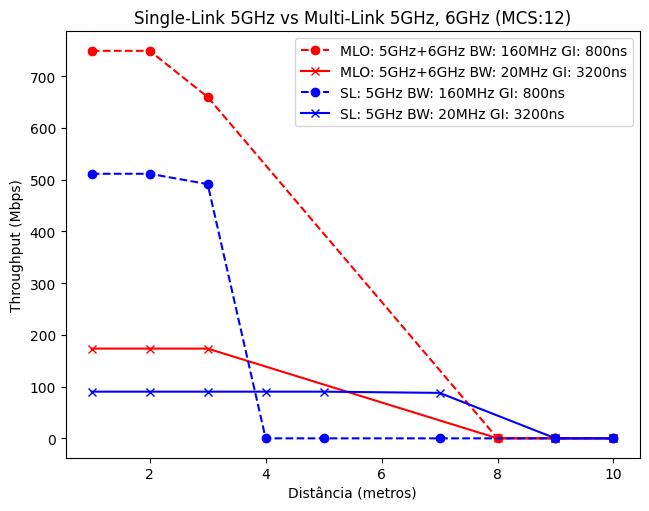

In [33]:
all_data["CW_GI"] = all_data["Channel_width"].astype(str) +"_"+  all_data["GI"].astype(str)
all_data["F1_F2"] = all_data["Frequency"].astype(str) +"_"+  all_data["Frequency2"].astype(str)

all_data = all_data.sort_values(by='Distance')


mlos = all_data['F1_F2'].unique()


mlo = '5.0_6.0'
filtered_by_mlo = all_data.filter(items=['F1_F2', 'CW_GI', 'Distance', 'Throughput'])\
        .where(all_data.F1_F2 == mlo)\
        .dropna(how='any')\
        .sort_values(by='Distance')

# Criando a figura e os subplots
fig = plt.plot(figsize=(13, 9))

nw_configs = ['160_800', '20_3200']

for i, nconfig in enumerate(nw_configs):
    print(nconfig)
    l1, l2 = mlo.split('_')
    filtrado = filtered_by_mlo.filter(items=['Distance','Throughput'])\
        .where(filtered_by_mlo.CW_GI == nconfig)\
        .dropna(how='any')\
        .sort_values(by='Distance')

    filtrado = filtrado.dropna(how='any')

    x = filtrado['Distance']
    y = filtrado['Throughput']
    
    # ax = axs.flat[i]
    # ax.plot(x, y, 'ro' , label=f'Subplot {nconfig}', )
    rede = nconfig.split('_')
    if i==0:
        plt.plot(x, y, '--o', color='red', label=f'MLO: {int(float(l1))}GHz+{int(float(l2))}GHz BW: {rede[0]}MHz GI: {rede[1]}ns', )
    else:
        plt.plot(x, y, '-x', color='red', label=f'MLO: {int(float(l1))}GHz+{int(float(l2))}GHz BW: {rede[0]}MHz GI: {rede[1]}ns', )
    # plt.set_title(f'config :{nconfig}')
    plt.legend()


mlo = '5.0_0.0'
filtered_by_mlo = all_data.filter(items=['F1_F2', 'CW_GI', 'Distance', 'Throughput'])\
        .where(all_data.F1_F2 == mlo)\
        .dropna(how='any')\
        .sort_values(by='Distance')

# Criando a figura e os subplots
fig = plt.plot(figsize=(13, 9))

nw_configs = ['160_800', '20_3200']

for i, nconfig in enumerate(nw_configs):
    print(nconfig)
    l1, l2 = mlo.split('_')
    filtrado = filtered_by_mlo.filter(items=['Distance','Throughput'])\
        .where(filtered_by_mlo.CW_GI == nconfig)\
        .dropna(how='any')\
        .sort_values(by='Distance')

    filtrado = filtrado.dropna(how='any')

    x = filtrado['Distance']
    y = filtrado['Throughput']
    
    # ax = axs.flat[i]
    # ax.plot(x, y, 'ro' , label=f'Subplot {nconfig}', )
    rede = nconfig.split('_')
    if i==0:
        plt.plot(x, y, '--o', color='blue', label=f'SL: {int(float(l1))}GHz BW: {rede[0]}MHz GI: {rede[1]}ns', )
    else:
        plt.plot(x, y, '-x', color='blue', label=f'SL: {int(float(l1))}GHz BW: {rede[0]}MHz GI: {rede[1]}ns', )
    # plt.set_title(f'config :{nconfig}')
    plt.legend()

    
    # filtrado.plot(x="Distance", y="Throughput")


# Ajustando o layout
plt.tight_layout()
l1, l2 = mlo.split('_')
if l2 == '0.0':
    titulo = f'Link em {l1} GHz'
else:
    titulo = f'Links em {l1} e {l2} GHz'

plt.title(f"Single-Link 5GHz vs Multi-Link 5GHz, 6GHz (MCS:12)")
plt.xlabel('Distância (metros)')
plt.ylabel('Throughput (Mbps)')
# Mostrando o gráfico

plt.savefig('MLO_5.png', dpi=300, bbox_inches='tight')
plt.show()

160_800
20_3200
160_800
20_3200


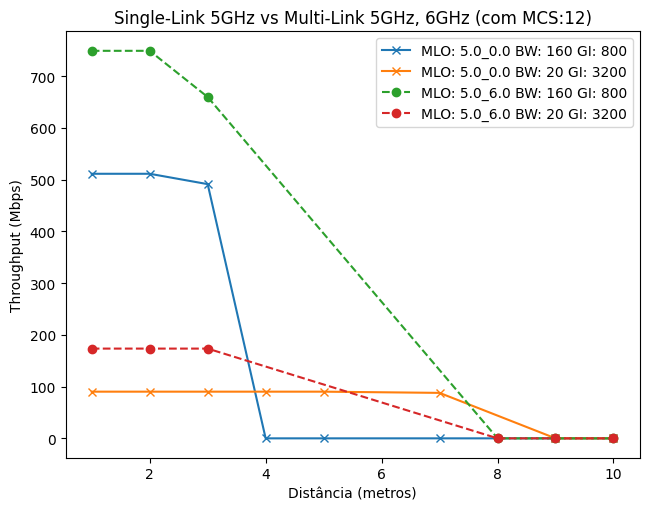

In [20]:
all_data["CW_GI"] = all_data["Channel_width"].astype(str) +"_"+  all_data["GI"].astype(str)
all_data["F1_F2"] = all_data["Frequency"].astype(str) +"_"+  all_data["Frequency2"].astype(str)

all_data = all_data.sort_values(by='Distance')


mlos = all_data['F1_F2'].unique()


mlo = '5.0_0.0'
filtered_by_mlo = all_data.filter(items=['F1_F2', 'CW_GI', 'Distance', 'Throughput'])\
        .where(all_data.F1_F2 == mlo)\
        .dropna(how='any')\
        .sort_values(by='Distance')

# Criando a figura e os subplots
fig = plt.plot(figsize=(12, 8))

nw_configs = ['160_800', '20_3200']

for i, nconfig in enumerate(nw_configs):
    print(nconfig)
    l1, l2 = mlo.split('_')
    filtrado = filtered_by_mlo.filter(items=['Distance','Throughput'])\
        .where(filtered_by_mlo.CW_GI == nconfig)\
        .dropna(how='any')\
        .sort_values(by='Distance')

    filtrado = filtrado.dropna(how='any')

    x = filtrado['Distance']
    y = filtrado['Throughput']
    
    # ax = axs.flat[i]
    # ax.plot(x, y, 'ro' , label=f'Subplot {nconfig}', )
    rede = nconfig.split('_')
    plt.plot(x, y, '-x', label=f'MLO: {mlo} BW: {rede[0]} GI: {rede[1]}', )
    # plt.set_title(f'config :{nconfig}')
    plt.legend()


mlo = '5.0_6.0'
filtered_by_mlo = all_data.filter(items=['F1_F2', 'CW_GI', 'Distance', 'Throughput'])\
        .where(all_data.F1_F2 == mlo)\
        .dropna(how='any')\
        .sort_values(by='Distance')

# Criando a figura e os subplots
fig = plt.plot(figsize=(12, 8))

nw_configs = ['160_800', '20_3200']

for i, nconfig in enumerate(nw_configs):
    print(nconfig)
    l1, l2 = mlo.split('_')
    filtrado = filtered_by_mlo.filter(items=['Distance','Throughput'])\
        .where(filtered_by_mlo.CW_GI == nconfig)\
        .dropna(how='any')\
        .sort_values(by='Distance')

    filtrado = filtrado.dropna(how='any')

    x = filtrado['Distance']
    y = filtrado['Throughput']
    
    # ax = axs.flat[i]
    # ax.plot(x, y, 'ro' , label=f'Subplot {nconfig}', )
    rede = nconfig.split('_')
    plt.plot(x, y, '--o', label=f'MLO: {mlo} BW: {rede[0]} GI: {rede[1]}', )
    # plt.set_title(f'config :{nconfig}')
    plt.legend()

    
    # filtrado.plot(x="Distance", y="Throughput")


# Ajustando o layout
plt.tight_layout()
l1, l2 = mlo.split('_')
if l2 == '0.0':
    titulo = f'Link em {l1} GHz'
else:
    titulo = f'Links em {l1} e {l2} GHz'

plt.title(f"Single-Link 5GHz vs Multi-Link 5GHz, 6GHz (com MCS:12)")
plt.xlabel('Distância (metros)')
plt.ylabel('Throughput (Mbps)')
# Mostrando o gráfico
plt.show()
